# MNIST手写数字识别实验
### 引入需要的python包

In [2]:
from __future__ import print_function
import numpy as np
import argparse
import os

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image

from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

### 使用本地的图片与标签
#### 从本地文件中加在图片与标签的函数

In [3]:
class LocalDataset(Dataset):
    def __init__(self, root_dir, record_dir, transform):
        super(LocalDataset, self).__init__()
        self.transform = transform
        self.root_dir = root_dir
        self.datas = self.read_samples_from_record(root_dir, record_dir)
        
    def __getitem__(self, index):
        path, target = self.datas[index]
        sample = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        sample = Image.fromarray(sample)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target
    
    def __len__(self):
        return len(self.datas)
    
    def read_samples_from_record(self, root_dir, record_dir):
        samples = []
        with open(record_dir, "r") as f:
            for index, line in enumerate(f):
                line = line.split()
                if len(line) < 2:
                    print('Error, Label is missing')
                    exit()
                else:
                    image_dir, label = line[0], line[1]
                label = int(label)
                image_dir = os.path.join(root_dir, image_dir)
                samples.append((image_dir, label))
        return samples

#### 加载数据

In [4]:
data_dir = 'data/mnist/' #放置本地mnist数据集的地址
train_label = 'data/mnist/mnist_classification_train.txt'
test_label = 'data/mnist/mnist_classification_test.txt'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

train_set = LocalDataset(data_dir, train_label, transform)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True)

test_set = LocalDataset(data_dir, test_label, transform)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=True)

### 查看数据集中的图片样本

In [5]:
def imshow(img):
    arr = img.numpy()
    plt.imshow(np.transpose(arr, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


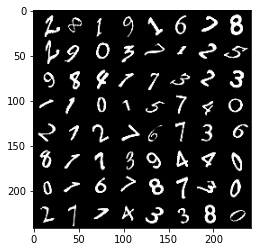

In [6]:
data = iter(train_loader)
images, labels = data.next()
imshow(torchvision.utils.make_grid(images))

### 搭建神经网络类CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### 使用CNN类创建神经网络模型

In [8]:
model = CNN()

### 训练函数

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

### 测试函数

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

### 设置模型训练的参数（优化器、学习率、训练周期数等）

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
device = torch.device("cpu") # or 'gpu'
losses = []
accuracies = []
epochs = 10

### 训练模型

In [12]:
for epoch in range(epochs):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

Train Epoch: 0 [3200/8000	(40%)]	Loss: 2.278951
Train Epoch: 0 [6400/8000	(80%)]	Loss: 2.251157

Test set: Average loss: 2.2150, Accuracy: 3069/8000 (38%)

Train Epoch: 1 [3200/8000	(40%)]	Loss: 2.134651
Train Epoch: 1 [6400/8000	(80%)]	Loss: 1.975634

Test set: Average loss: 1.8788, Accuracy: 4428/8000 (55%)

Train Epoch: 2 [3200/8000	(40%)]	Loss: 1.595710
Train Epoch: 2 [6400/8000	(80%)]	Loss: 1.451364

Test set: Average loss: 1.2600, Accuracy: 4790/8000 (60%)

Train Epoch: 3 [3200/8000	(40%)]	Loss: 1.118890
Train Epoch: 3 [6400/8000	(80%)]	Loss: 1.001027

Test set: Average loss: 0.9713, Accuracy: 5470/8000 (68%)

Train Epoch: 4 [3200/8000	(40%)]	Loss: 0.850131
Train Epoch: 4 [6400/8000	(80%)]	Loss: 0.823736

Test set: Average loss: 0.7369, Accuracy: 6113/8000 (76%)

Train Epoch: 5 [3200/8000	(40%)]	Loss: 0.584044
Train Epoch: 5 [6400/8000	(80%)]	Loss: 0.811376

Test set: Average loss: 0.5647, Accuracy: 6611/8000 (83%)

Train Epoch: 6 [3200/8000	(40%)]	Loss: 0.413643
Train Epoch: 6 [

### 保存训好的模型参数

In [13]:
OUT_PATH = 'weights/mnist-epoch'+str(epochs)+'.pth'
torch.save(model.state_dict(), OUT_PATH)

### 绘制训练过程中的loss下降曲线

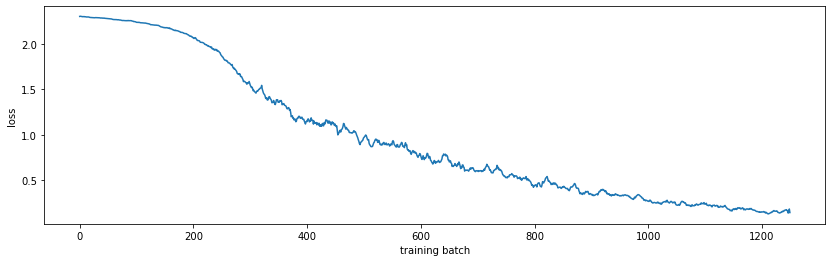

In [14]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

### 绘制训练过程中的准确率上升曲线

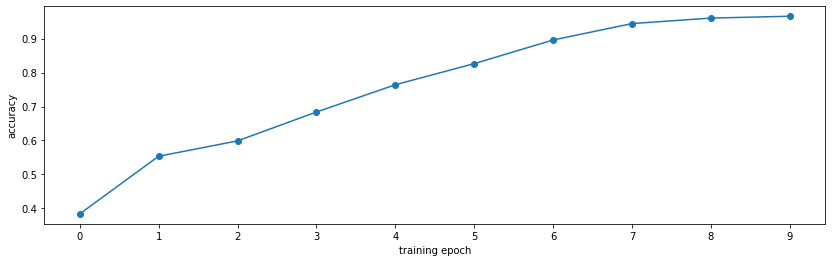

In [15]:
plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies, marker='o')

### 查看测试集上的图片样本

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


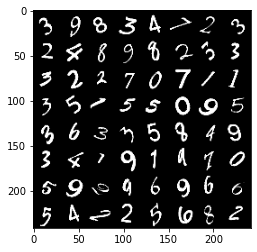

In [16]:
data = iter(test_loader)
images, labels = data.next()
imshow(torchvision.utils.make_grid(images))

### 查看对应模型输出

In [17]:
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ')
predicted = np.array(predicted)
for i in range(8):
    cur_out = predicted[i*8:(i+1)*8]
    res = ' '.join('%5s' % cur_out[j] for j in range(8))
    print(res)

Predicted: 
    3     9     8     3     4     7     2     3
    2     4     8     9     8     2     3     3
    3     2     2     7     0     7     1     1
    3     5     7     5     5     0     9     5
    3     6     3     5     5     8     4     9
    3     4     1     9     1     9     7     0
    5     9     2     9     6     9     6     6
    5     4     2     2     5     6     8     2
